In [6]:
# Library imports.
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import numpy as np
import pandas as pd
from scipy import stats

# Local imports.
from urbansurge import swmm_model, analysis_tools, file_utils
from urbansurge.sensing import sensor_utils

# Autoreload jupyter.
%load_ext autoreload
%autoreload 2

### Configurations.

In [7]:
# Model table filepath.
mod_table_fp = r"C:\Users\ay434\Documents\urbansurge\analysis\lab_system\Output\Precip_Noise\healthy_Pmeas.csv"

# Fault table filepath.
meas_table_fp = r"C:\Users\ay434\Documents\urbansurge\analysis\lab_system\Output\Precip_Noise\roughness_54.csv"

# Input and configuration file paths for swmm model.
inp_filepath = r"C:\Users\ay434\Documents\urbansurge\analysis\lab_system\lab_system.inp"
cfg_filepath = r"C:\Users\ay434\Documents\urbansurge\analysis\lab_system\lab_system_config.yml"

# Number of upstream locations for sensor array.
Nups = 3

# Fault value index.
fault_value_idx = 9

# Training period in time steps.
N_train = 2000

# Fault time step.
T_fault = 3000

### Modeled system states

In [8]:
# Load in healthy data.
mod_table = pd.read_csv(mod_table_fp)
mod_table['datetime'] = pd.to_datetime(mod_table['datetime'])

### Measured system states

In [9]:
# Load in measured fault table
meas_table = pd.read_csv(meas_table_fp)

# Fault values
fault_values = np.unique(meas_table['fault_value'])

# Specific fault value.
fault_value = fault_values[fault_value_idx]

print(fault_value / 0.01 * 100)

# Select out data from fault value.
fault_table = meas_table.loc[meas_table['fault_value'] == fault_value, :]

526.3157894736839


In [10]:
print(fault_value)

0.0526315789473684


In [11]:
# Add in healthy data for pre-fault period.
healthy_train_table = meas_table.loc[meas_table['fault_value'] == fault_values[0], :]
fault_table.iloc[:T_fault, :] = healthy_train_table.iloc[:T_fault, :]

# Convert datetime.
fault_table['datetime'] = pd.to_datetime(fault_table['datetime'])

# Rename to meas_table.
meas_table = fault_table.copy()

C:\Users\ay434\AppData\Local\Temp\ipykernel_15616\1607648352.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fault_table['datetime'] = pd.to_datetime(fault_table['datetime'])


### Assign sensor locations

In [12]:
# Link-Node dictionary.
link_node_dict = sensor_utils.link_nodes(inp_filepath, int_convert=False)

# Sensor links.
sensor_locations = sensor_utils.upstream_assign_links(link_node_dict, inp_filepath, Nups=Nups, exclude_weirs=True)
print(sensor_locations)

['21', '44', '41', '20', '52', '63', '38', '45', '60', '54', '26']


In [14]:
# Create the sensor network.
sensor_network = sensor_utils.SensorNetwork()

# Add depth and velocity sensors.
for sensor_location in sensor_locations:
    # Extract modeled data.
    mod_times = mod_table['datetime']
    mod_depth = mod_table[f'Depth_link_{sensor_location}'].to_numpy()
    mod_velocity = mod_table[f'Velocity_link_{sensor_location}'].to_numpy()
    mod_flow = mod_table[f'Flow_link_{sensor_location}'].to_numpy()
    
    # Extract measured data.
    meas_times = meas_table['datetime']
    meas_depth = meas_table[f'Depth_link_{sensor_location}'].to_numpy()
    meas_velocity = meas_table[f'Velocity_link_{sensor_location}'].to_numpy()
    meas_flow = meas_table[f'Flow_link_{sensor_location}'].to_numpy()
    
    # Sensor configurations.
    sensor_id = sensor_location
    component_id = sensor_location
    component_type = 'conduit'
    dt = (mod_times[1] - mod_times[0]).total_seconds() / 60
    
    # Create depth sensor.
    depth_units = 'ft'
    depth_sensor = sensor_utils.DepthSensor(sensor_id=sensor_id, units=depth_units, cfg_filepath=cfg_filepath, 
                                            component_id=component_id, component_type=component_type, dt=dt, time=mod_times, 
                                            measure_data=meas_depth, model_data=mod_depth)
    
    # Create velocity sensor.
    velocity_units = 'fps'
    velocity_sensor = sensor_utils.VelocitySensor(sensor_id=sensor_id, units=velocity_units, cfg_filepath=cfg_filepath, 
                                            component_id=component_id, component_type=component_type, dt=dt, time=mod_times, 
                                            measure_data=meas_velocity, model_data=mod_velocity)
    
    # Create flow sensor.
    flow_units = 'cfs'
    flow_sensor = sensor_utils.FlowSensor(sensor_id=sensor_id, units=flow_units, cfg_filepath=cfg_filepath, 
                                            component_id=component_id, component_type=component_type, dt=dt, time=mod_times, 
                                            measure_data=meas_flow, model_data=mod_flow)
    
    # Add to sensor network.
    sensor_network.add_depth_sensor(depth_sensor)
    sensor_network.add_velocity_sensor(velocity_sensor)
    sensor_network.add_flow_sensor(flow_sensor)
    
# Add rain gauge.
rain_gauge_id = 1
rain_gauge_units = 'in/hr'
rain_gauge_meas = meas_table['prcp'].to_numpy()
rain_gauge_mod = mod_table['prcp'].to_numpy()
rain_gauge = sensor_utils.RainGauge(sensor_id=rain_gauge_id, units=rain_gauge_units, dt=dt, time=mod_times, 
                                    measure_data=rain_gauge_mod)
sensor_network.add_rain_gauge(rain_gauge)

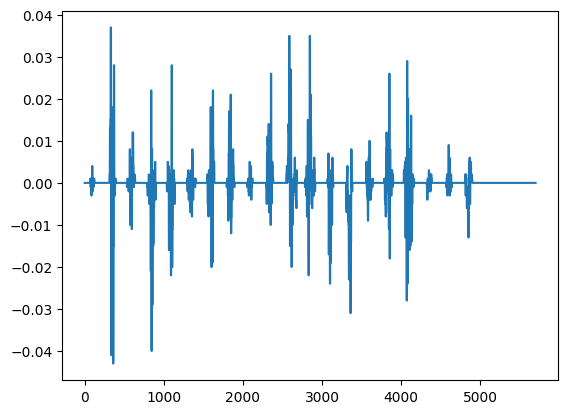

In [15]:
# Plot example depth sensor data.
depth_sensor = sensor_network.depth_sensors[sensor_locations[0]]

fig, ax = plt.subplots()
ax.plot(rain_gauge_mod - rain_gauge_meas)

### Training period

In [16]:
# Compute depth residual for all sensors.
for sensor_id, sensor in sensor_network.depth_sensors.items():
    sensor.compute_residual()

# Compute velocity residual for all sensors.
for sensor_id, sensor in sensor_network.velocity_sensors.items():
    sensor.compute_residual()

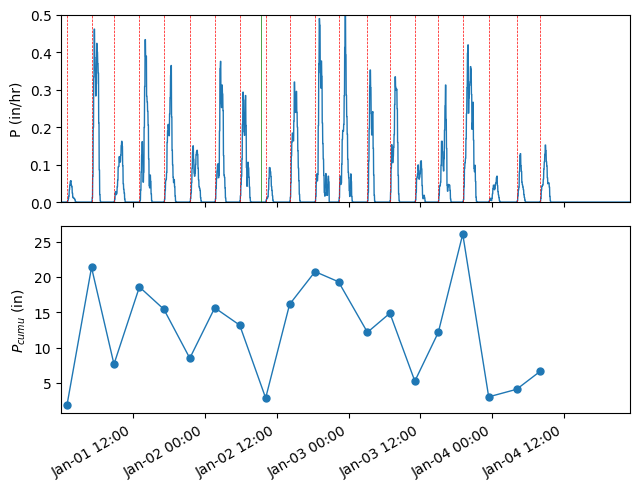

In [17]:
# Find storms from precipitation.
storm_threshold = 0.001
for rain_gauge_id, rain_gauge in sensor_network.rain_gauges.items():
    rain_gauge.find_storms(storm_threshold)
    rain_gauge.compute_cumu_storm_prcp()
    rain_gauge.compute_max_storm_prcp()
    
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(6.5,5))
ax1.plot(mod_times, rain_gauge.measure_data, linewidth=1)
ax1.vlines(x=mod_times[rain_gauge.storm_start_idx], ymin=0, ymax=0.75, color='r', linewidth=0.5, linestyle='dashed')
ax1.vlines(x=mod_times[N_train], ymin=0, ymax=0.75, color='g', linewidth=0.5)
ax1.set_ylim([0, 0.5])
ax1.set_xlim([mod_times[0], mod_times[rain_gauge.storm_end_idx[-1]]])
ax1.set_ylabel('P (in/hr)')
ax1.xaxis.set_major_formatter(mdates.DateFormatter('%b-%d %H:%M'))
fig.autofmt_xdate()

# Cumulative precipitation.
ax2.plot(mod_times[rain_gauge.storm_start_idx], rain_gauge.cumu_storm_prcp, marker='o', markersize=5, linewidth=1)
ax2.set_xlim([mod_times[0], mod_times[rain_gauge.storm_end_idx[-1]]])
ax2.set_ylabel('$P_{cumu}$ (in)')
ax2.xaxis.set_major_formatter(mdates.DateFormatter('%b-%d %H:%M'))
fig.autofmt_xdate()
fig.tight_layout()

# fig.savefig(r"C:\Users\ay434\Box\Research\Smart_Stormwater\Manuscript\Figures\prcp_noise_storms.png", dpi=300)

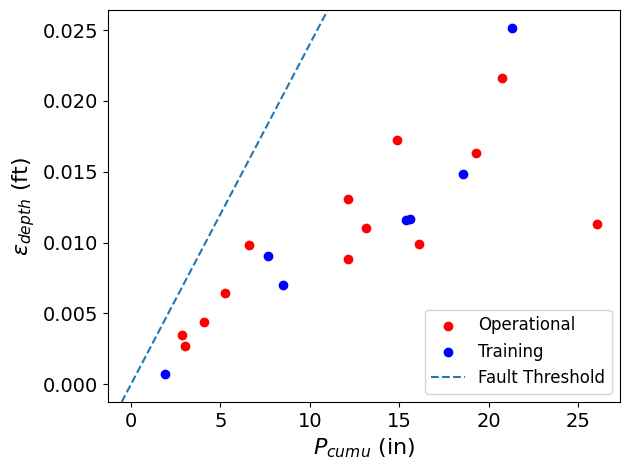

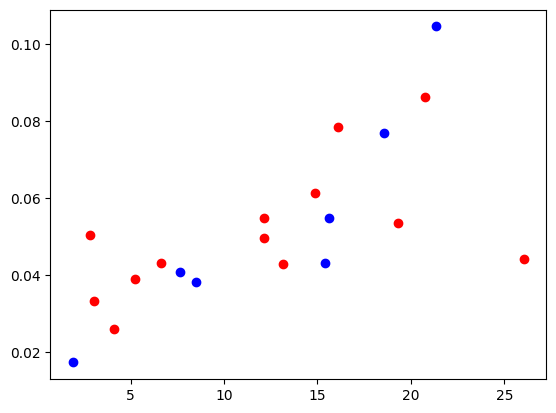

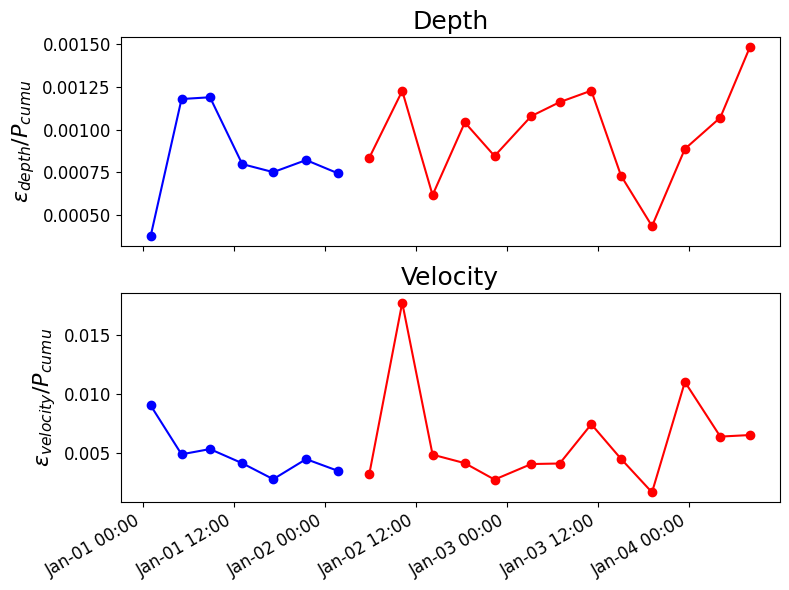

In [18]:
velocity_sensor = sensor_network.velocity_sensors[sensor_locations[4]]
depth_sensor = sensor_network.depth_sensors[sensor_locations[4]]

# Plot maximum residual as a function of cumulative precipitation.
max_depth_residuals_train = []
max_velocity_residuals_train = []
max_depth_residuals = []
max_velocity_residuals = []
prcp_train = []
prcp_oper = []
for i in range(rain_gauge.n_storms):
    # Start and end indices for storm.
    storm_start_idx = rain_gauge.storm_start_idx[i]
    storm_end_idx = rain_gauge.storm_end_idx[i]
    
    # Maximum residuals for storm.
    if storm_end_idx < N_train:
        max_depth_residuals_train.append(np.max(np.abs(depth_sensor.residual[storm_start_idx:storm_end_idx])))
        max_velocity_residuals_train.append(np.max(np.abs(velocity_sensor.residual[storm_start_idx:storm_end_idx])))
        prcp_train.append(rain_gauge.cumu_storm_prcp[i])
    else:     
        max_depth_residuals.append(np.max(np.abs(depth_sensor.residual[storm_start_idx:storm_end_idx])))
        max_velocity_residuals.append(np.max(np.abs(velocity_sensor.residual[storm_start_idx:storm_end_idx])))
        prcp_oper.append(rain_gauge.cumu_storm_prcp[i])
    
fig, ax = plt.subplots()
ax.scatter(prcp_oper, max_depth_residuals, c='red', label='Operational')
ax.scatter(prcp_train, max_depth_residuals_train, c='blue', label='Training')
ax.axline([0, 0], slope=0.0024, linestyle='dashed', label='Fault Threshold')
ax.legend(fontsize=12)
ax.set_xlabel('$P_{cumu}$ (in)', fontsize=16)
ax.set_ylabel('$\epsilon_{depth}$ (ft)', fontsize=16)
ax.tick_params(axis='both', labelsize=14)
fig.tight_layout()
# fig.savefig(r"C:\Users\ay434\Box\Research\Smart_Stormwater\Manuscript\Figures\residual_Pcumu_scatter.png", dpi=300)

fig, ax = plt.subplots()
ax.scatter(prcp_oper, max_velocity_residuals, c='red')
ax.scatter(prcp_train, max_velocity_residuals_train, c='blue')

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8,6))
ax1.plot(mod_times[rain_gauge.storm_start_idx[:7]], np.array(max_depth_residuals_train) / np.array(prcp_train), 'b-o')
ax1.plot(mod_times[rain_gauge.storm_start_idx[7:]], np.array(max_depth_residuals) / np.array(prcp_oper), 'r-o')
ax1.xaxis.set_major_formatter(mdates.DateFormatter('%b-%d %H:%M'))
ax1.set_ylabel('$\epsilon_{depth} / P_{cumu}$', fontsize=16)
ax1.tick_params(axis='both', labelsize=12)
ax1.set_title('Depth', fontsize=18)

ax2.plot(mod_times[rain_gauge.storm_start_idx[:7]], np.array(max_velocity_residuals_train) / np.array(prcp_train), 'b-o')
ax2.plot(mod_times[rain_gauge.storm_start_idx[7:]], np.array(max_velocity_residuals) / np.array(prcp_oper), 'r-o')
ax2.xaxis.set_major_formatter(mdates.DateFormatter('%b-%d %H:%M'))
ax2.set_ylabel('$\epsilon_{velocity} / P_{cumu}$', fontsize=16)
ax2.tick_params(axis='both', labelsize=12)
ax2.set_title('Velocity', fontsize=18)

fig.autofmt_xdate()
fig.tight_layout()

# fig.savefig(r"C:\Users\ay434\Box\Research\Smart_Stormwater\Manuscript\Figures\residual_Pcumu_ratio.png", dpi=300)

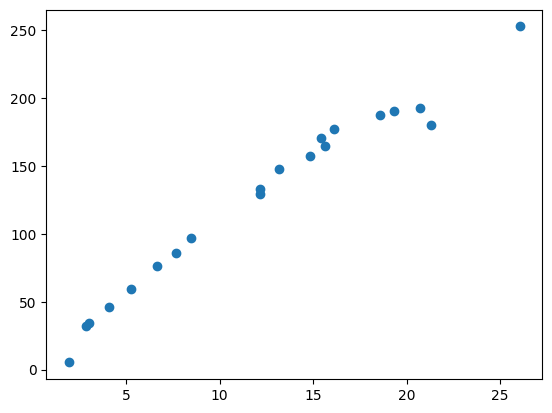

In [37]:
# Compute cumulative storm flow.
flow_sensor = sensor_network.flow_sensors[sensor_locations[6]]
cumu_storm_flow = flow_sensor.compute_cumu_storm_flow(rain_gauge.storm_start_idx, rain_gauge.storm_end_idx)

fig, ax = plt.subplots()
ax.scatter(rain_gauge.cumu_storm_prcp, cumu_storm_flow)

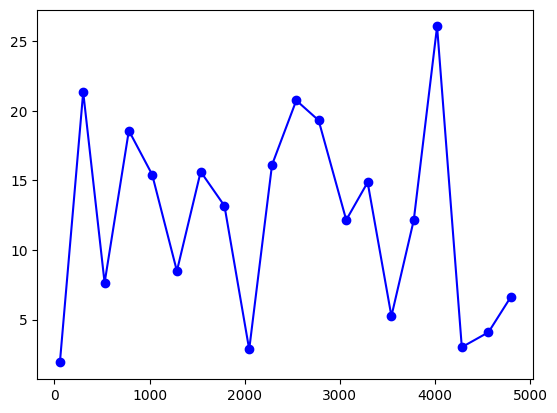

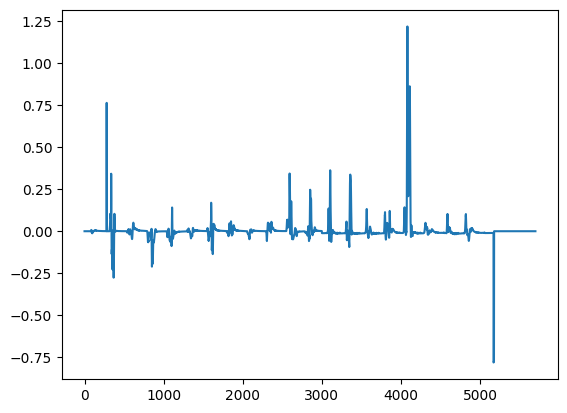

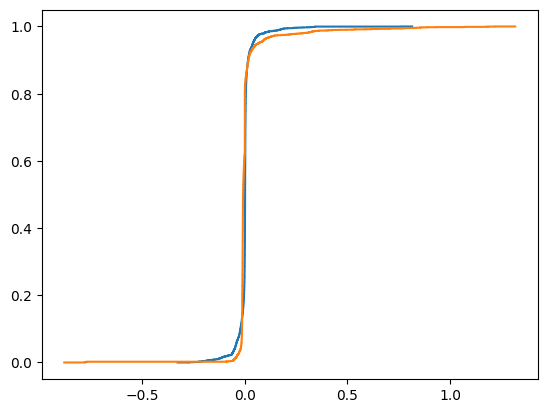

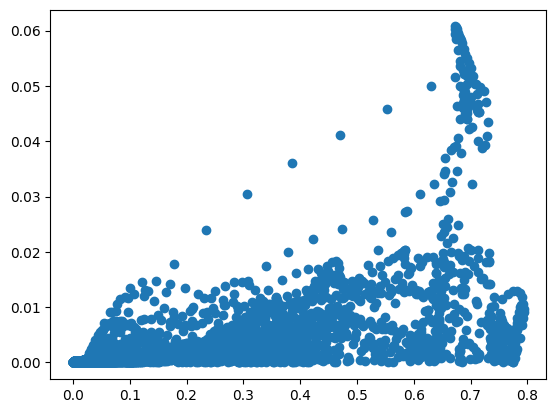

In [109]:
# Empirical CDFs.
res = stats.ecdf(velocity_sensor.residual[:N_train])
res_operational = stats.ecdf(velocity_sensor.residual[N_train:])

fig, ax = plt.subplots()
ax.plot(rain_gauge.storm_start_idx, rain_gauge.cumu_storm_prcp, 'b-o')

fig, ax = plt.subplots()
ax.plot(velocity_sensor.residual)

fig, ax = plt.subplots()
res.cdf.plot(ax)
res_operational.cdf.plot(ax)

fig, ax = plt.subplots()
ax.scatter(depth_sensor.measure_data, np.abs(depth_sensor.residual))
